# ML2 | Pollution Prediction Project
**MAI 2023/24 USC | Online Learning Project**

This Jupyter Notebook is part of the Online Learning Project for the Machine Learning 2 course at the University of Santiago de Compostela. The project uses data from this Kaggle [Data Repository](https://www.kaggle.com/datasets/rupakroy/lstm-datasets-multivariate-univariate). 


**Authors:**
- Brian García Machado
- Fernando Núnez Sánchez
- Marcin Jedrzejowski 
- Santiago Suárez Carrera


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Problem description

### Informal Problem Description
Predicting pollution levels (PM2.5) is crucial for public health and environmental policy-making. This project aims to forecast pollution levels 24 hours ahead using weather forecasts and current pollution data.

### ML Problem Characteristics
The problem at hand is time series forecasting of pollution levels 24 hours in advance. 

The dataset employed captures various atmospheric conditions and pollution levels recorded hourly over five years at the US embassy in Beijing, China. This dataset includes critical features such as temperature, dew point, pressure, wind direction, and speed, alongside the target variable, PM2.5 concentration. The challenge squarely falls within the realm of regression problems, a subset of time series forecasting. The distribution of pollution levels is skewed towards lower values, with fewer high-peak events. This imbalance highlights the challenges in accurately predicting higher levels of pollution due to their less frequent occurrence.

Given the regression nature of the problem, we select Mean Absolute Error (MAE) as our evaluation metric, particularly suitable for its simplicity and interpretability in quantifying the average magnitude of errors in predictions. The MAE is calculated as the average of the absolute differences between the predicted values and actual values, formalized as:

$$
\text{MAE} = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

The potential for concept drift is a crucial consideration in environmental data analysis. Seasonal variations, changes in urban infrastructure, or shifts in environmental policies can influence pollution levels over time. These factors mean the patterns the model learns may change, necessitating ongoing model evaluation and potentially retraining to maintain forecasting accuracy.

Finally, the fundamental assumption in our forecasting model is that the dataset's features, which are actual measurements of physical conditions like temperature, pressure, and wind speed, are treated as if they were forecasted predictions. This approach allows us to simulate a real-world scenario, where the features represent anticipated conditions, thereby enabling us to forecast pollution levels 24 hours in advance based on these 'predicted' values.

## 2. Dataset Selection

### Dataset Overview

For this project, we have chosen a comprehensive [dataset](https://www.kaggle.com/datasets/rupakroy/lstm-datasets-multivariate-univariate) on air pollution, specifically focusing on PM2.5 particle measurements. The dataset comprises several weather-related features alongside the pollution readings, recorded hourly. Our primary goal is to predict future pollution levels (24 hours ahead) based on current weather conditions and pollution data. This predictive model could serve as a tool for early warning systems to mitigate the adverse effects of air pollution on health and the environment. The issue with the distribution of rain, snow and wind speed is similar.

This dataset is particularly suited for our task due to its detailed hourly recordings of weather conditions and pollution levels, enabling the development of an Online Learning Machine Learning model. Regarding data preparation, the dataset will require specific preparatory steps, such as the creation of a target variable by shifting the current pollution by 24 hours and the encoding of the wind direction feature.

### Dataset Characteristics

The dataset includes the following features:

- `date`: Timestamp of the observation (hourly data)
- `pollution`: PM2.5 concentration
- `dew`: Dew point
- `temp`: Temperature
- `press`: Pressure
- `wnd_dir`: Wind direction
- `wnd_spd`: Wind speed
- `snow`: Snowfall
- `rain`: Rainfall

#### Initial Data Analysis


In [2]:
# Loading the dataset
dataset = pd.read_csv('data/air_pollution_dataset.csv')
dataset.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [3]:
dataset.size

394200

In [4]:
# Checking for null values
dataset.isnull().sum()

date         0
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

In [5]:
# Statistical summary of the dataset
dataset.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [6]:
# Unique values in 'wnd_dir' column
print(dataset['wnd_dir'].unique())


['SE' 'cv' 'NW' 'NE']


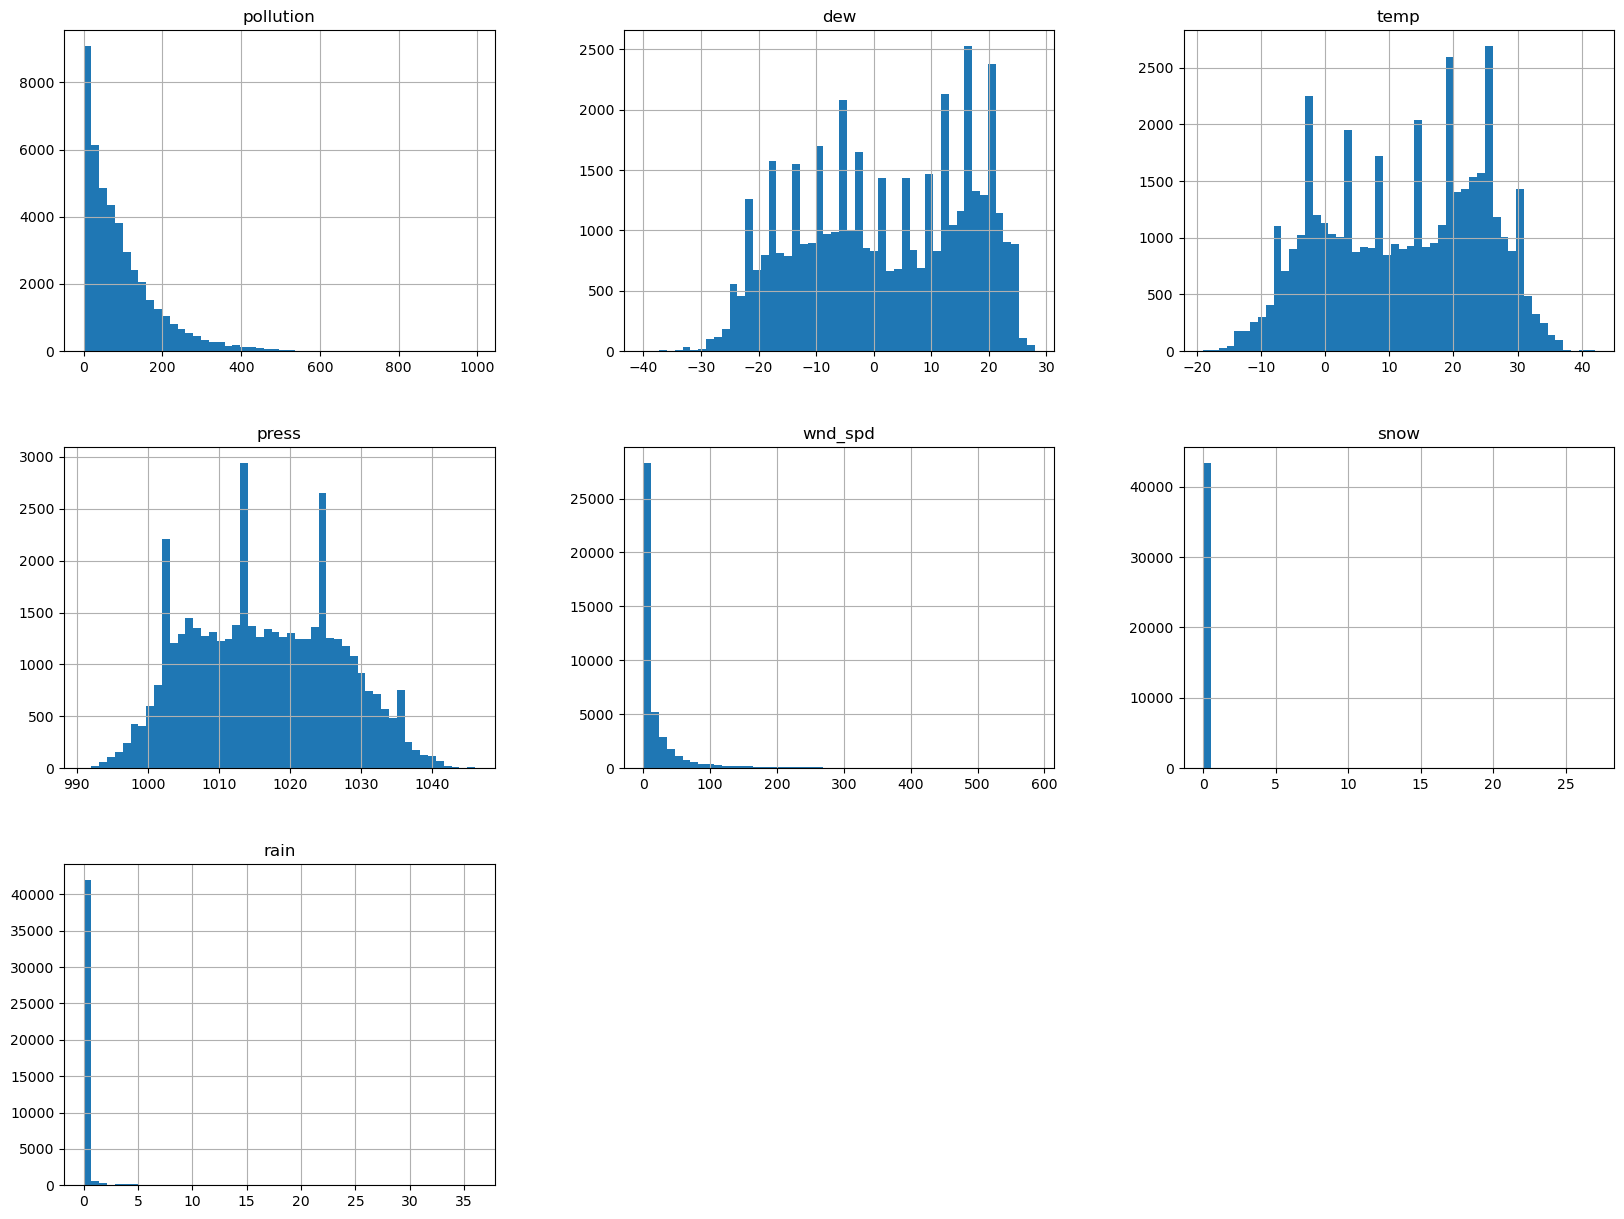

In [7]:
# Data distribution
dataset.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
df = pd.read_csv('data/air_pollution_dataset.csv')

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['date'] = df['date'].map(lambda x: x.replace(year=2000))
grouped = df.groupby(['year', 'date']).mean().reset_index()
for year in grouped['year'].unique():
    plt.plot(grouped[grouped['year'] == year]['date'], grouped[grouped['year'] == year]['pollution'], label=year)
plt.legend()
plt.show()

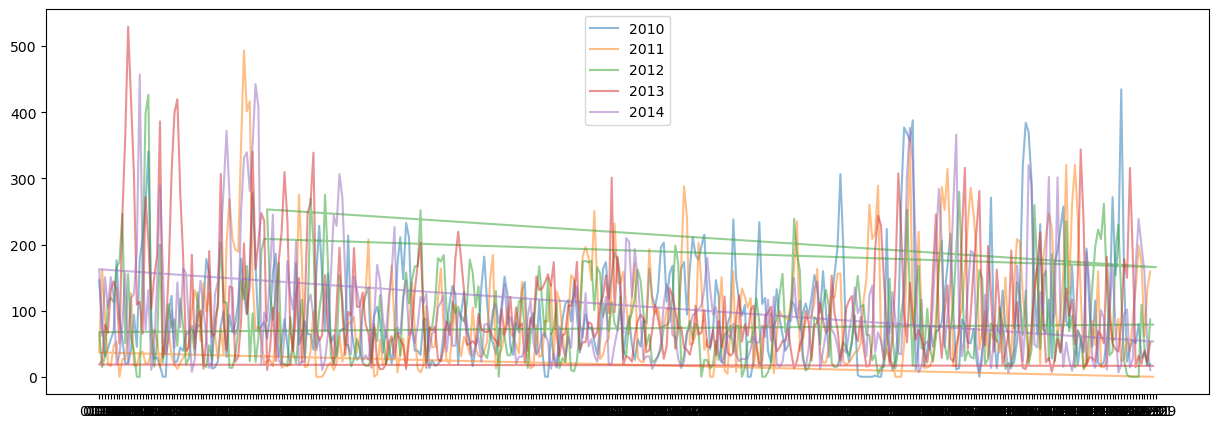

In [8]:
df = pd.read_csv('data/air_pollution_dataset.csv')

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df['month-day'] = df.index.strftime('%m-%d')
df['year'] = df.index.year
df_grouped = df.groupby(['year', 'month-day'])['pollution'].mean().reset_index()
# Crea un gráfico para cada año
plt.figure(figsize=(15, 5))
for year in df_grouped['year'].unique():
    df_year = df_grouped[df_grouped['year'] == year]
    plt.plot(df_year['month-day'], df_year['pollution'], label=year, alpha=0.5)
plt.legend()
plt.show()

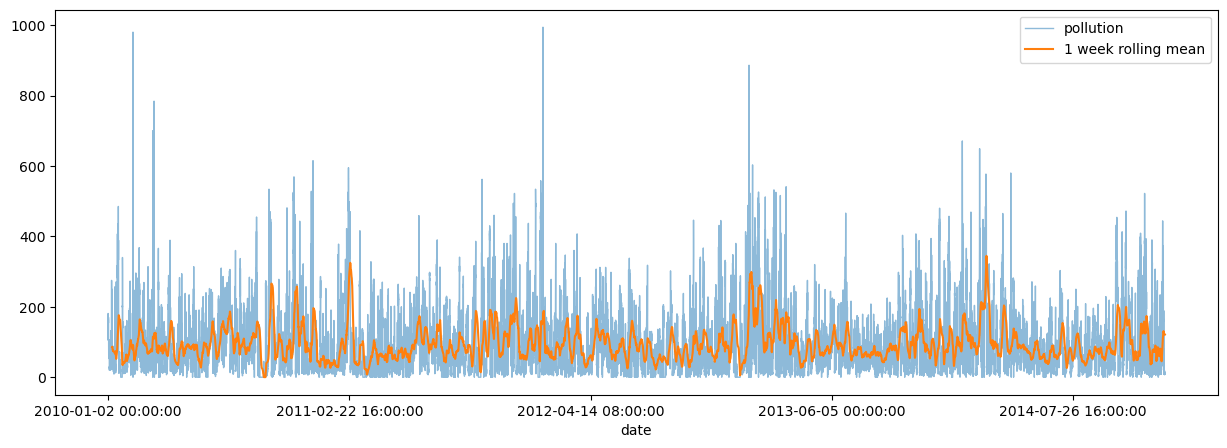

In [9]:
# Plotting the pollution data and its 1 week rolling mean
dataset.plot(x='date', y='pollution', linewidth=1, alpha=0.5, figsize=(15, 5))
dataset['pollution'].rolling(window=168).mean().plot(figsize=(15, 5), label='1 week rolling mean')
plt.legend()

### * Add something about how the data is structured, outliers (mirar en internet se valores de 1000 son ok)

## 3. Data Preparation 
Following an analysis of the dataset, including the graphs and descriptive statistics of the previous section, we identified the need for data type conversions to accommodate River's requirements.

To align with our objective, we will perform the following data preparation steps:

1. **Shift the `pollution` column by 24 hours** to create the `current_pollution` variable. This aligns the pollution data with the timeframe of our forecasting target, enabling the model to predict future pollution levels based on current and past observations.
2. **Forecast Weather Features**: For the purpose of this project, we will treat the weather features as if they were forecasts for the next 24 hours, at the time of the pollution to be predicted. This simplification assumes the availability of accurate weather forecasts.
3. **Encode the `wnd_dir` categorical variable**: Given that `wnd_dir` contains string values representing wind directions, and considering the dynamic nature of wind direction in an online learning context where new directions may emerge, one-hot encoding is applied. This encoding transforms wnd_dir into a format amenable to our machine learning models, facilitating the incorporation of wind direction as a predictive feature without assuming a fixed set of possible values.
4. **Standarization of numerical features**: Instead of normalizing the data, we have chosen to standardize all numerical features (excluding wind direction) using River's `StandardScaler`, as our analysis indicated standardization is preferable over normalization for this context. It maintains the relative scales and distributions of features, crucial for our model's accuracy.

These preparation steps will transform the raw dataset into a structured format that our machine learning models can efficiently process to predict future pollution levels.

In [10]:
# Loading the dataset
dataset = pd.read_csv('data/air_pollution_dataset.csv')

In [11]:
# Step 1: Create target variable by shifting pollution
hours_shifted = 24
dataset['current_pollution'] = dataset['pollution'].shift(hours_shifted)

# Rename the pollution column to pred_pollution
dataset = dataset.rename(columns={'pollution': 'pred_pollution'})

# Drop the last 24 rows where pollution_24 is NaN due to shifting
dataset = dataset.iloc[hours_shifted:]
dataset = dataset.reset_index(drop=True)

In [12]:
dataset.head()

,date,pred_pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,current_pollution
0,2010-01-03 00:00:00,90.0,-7,-6.0,1027.0,SE,58.56,4,0,129.0
1,2010-01-03 01:00:00,63.0,-8,-6.0,1026.0,SE,61.69,5,0,148.0
2,2010-01-03 02:00:00,65.0,-8,-7.0,1026.0,SE,65.71,6,0,159.0
3,2010-01-03 03:00:00,55.0,-8,-7.0,1025.0,SE,68.84,7,0,181.0
4,2010-01-03 04:00:00,65.0,-8,-7.0,1024.0,SE,72.86,8,0,138.0


In [13]:
dataset.to_csv('data/air_pollution_dataset_modified.csv', index=False)

## 4. Concept Drifts 

In the realm of stream learning, concept drift is a critical aspect to monitor and manage. Concept drift occurs when the statistical properties of the target variable, which the model is trying to predict, change over time. This can significantly impact the performance of machine learning models, making it crucial to detect and adapt to these changes promptly.

### Implemented Detectors

For this project, we will implement two concept drift detectors from the River library to monitor potential drifts in pollution levels:

1. **ADWIN (Adaptive Windowing):** ADWIN is a change detector that automatically adjusts the size of the window by cutting the window at different points depending on the data's variance. This method helps in detecting changes in the average of a stream without needing to define a window size a priori.

2. **Page-Hinkley:** The Page-Hinkley test is a sequential analysis technique used to detect changes in the average of a Gaussian signal. It is particularly useful for detecting abrupt changes in streams.

### Monitoring Concept Drift

By implementing these detectors, we aim to monitor the stream of pollution data for any significant changes that could indicate concept drift. Detecting such drifts allows us to update or retrain our models to maintain high accuracy and relevance despite the changing dynamics of air pollution.

#### ADWIN Implementation

<div style="background-color:#f5f5f5; padding:15px; border-radius:5px; width:94%;">

```python
from river import drift
from river import stream

adwin_detector = drift.ADWIN()
for i, (x, y) in enumerate(stream.iter_sklearn_dataset(dataset)):
    prediction = model.predict_one(x)
    adwin_detector.update(y - prediction)
    if adwin_detector.change_detected:
        print(f"Change detected at index {i}, retraining the model...")
        # Code to retrain the model
```

</div>


#### Page-Hinkley Implementation

<div style="background-color:#f5f5f5; padding:15px; border-radius:5px; width:94%;">

```python
ph_detector = drift.PageHinkley()
for i, (x, y) in enumerate(stream.iter_sklearn_dataset(dataset)):
    prediction = model.predict_one(x)
    ph_detector.update(y - prediction)
    if ph_detector.change_detected:
        print(f"Change detected at index {i}, retraining the model...")
        # Code to retrain the model
```

</div>

By employing these concept drift detectors, we ensure our model remains adaptive and responsive to the evolving patterns of air pollution, thereby maintaining its predictive performance over time.


## 5. Batch Learning with Base Model 

To establish a benchmark for our stream learning models, we'll start with a traditional batch learning approach using various models. For consistency and comparability, we'll select models that are also available in River, allowing for a direct comparison between batch and online learning performances later on, with the choice of a Random Forest, a Linear Regressor, a Decision Tree, and a KNN designed to offer a broad perspective on learning strategies and ensure a robust baseline for comparison.

### Model Training and Evaluation
We'll split our prepared dataset into training and testing sets, train the mentioned models on the training set applying cross-validation (5 folds), and evaluate its performance on the testing set. The performance metric of interest will be Mean Absolute Error (MAE) as stated previously.

#### Data preparation

In [14]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [15]:
dataset = pd.read_csv('data/air_pollution_dataset_modified.csv')
# Perform one-hot encoding on the 'wnd_dir' column
dataset = pd.get_dummies(dataset, columns=['wnd_dir'])

In [16]:
# Rename pollution as pred_pollution for clarity
dataset.rename(columns={'pollution': 'pred_pollution'}, inplace=True)

# Rearrange the columns
dataset = dataset[['date', 'current_pollution', 'dew', 'temp', 'press', 'wnd_spd', 'wnd_dir_NE', 'wnd_dir_NW', 'wnd_dir_SE', 'wnd_dir_cv', 'snow', 'rain', 'pred_pollution']]

dataset.head()

,date,current_pollution,dew,temp,press,wnd_spd,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv,snow,rain,pred_pollution
0,2010-01-03 00:00:00,129.0,-7,-6.0,1027.0,58.56,False,False,True,False,4,0,90.0
1,2010-01-03 01:00:00,148.0,-8,-6.0,1026.0,61.69,False,False,True,False,5,0,63.0
2,2010-01-03 02:00:00,159.0,-8,-7.0,1026.0,65.71,False,False,True,False,6,0,65.0
3,2010-01-03 03:00:00,181.0,-8,-7.0,1025.0,68.84,False,False,True,False,7,0,55.0
4,2010-01-03 04:00:00,138.0,-8,-7.0,1024.0,72.86,False,False,True,False,8,0,65.0


In [17]:
# Drop the date column and prepare features and target
bash_dataset = dataset.drop(columns='date')
X = bash_dataset.drop(columns=['pred_pollution'])
y = bash_dataset['pred_pollution'].values

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

# Define the MAE scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mae_bl_results = {}

# Define a deterministic cross-validation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define transformer for scaling
columns_to_scale = ['current_pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columns_to_scale)
    ],
    remainder='passthrough'  # Keep the one-hot encoded 'wnd_dir' columns as is
)

#### Random Forest Regressor

In [18]:
# Initialize the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the pipeline with preprocessing steps and the model to be used
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Perform cross-validation and calculate scores
scores = cross_val_score(pipe, X, y, scoring=mae_scorer, cv=cv)
mae_bl_results['Random Forest Regressor'] = scores

# Display results
print(f'MAE = {-scores.mean():.4f} (± {scores.std():.4f})')

MAE = 39.0316 (± 0.3901)


### Linear Regression

In [19]:
# Initialize the LinearRegression model
model = LinearRegression()

# Define the pipeline with preprocessing steps and the model to be used
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])
scores = cross_val_score(pipe, X, y, scoring=mae_scorer, cv=cv)
mae_bl_results['Linear Regression'] = scores
print(f'MAE = {-scores.mean():.4f} (± {scores.std():.4f})')

MAE = 54.4235 (± 0.6271)


### Decision Tree Regressor

In [20]:
# Initialize the DecisionTreeRegressor model
model = DecisionTreeRegressor()

# Define the pipeline with preprocessing steps and the model to be used
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])

scores = cross_val_score(pipe, X, y, scoring=mae_scorer, cv=cv)
mae_bl_results['Decision Tree Regressor'] = scores
print(f'MAE = {-scores.mean():.4f} (± {scores.std():.4f})')

MAE = 50.4398 (± 0.2888)


### KNN Regressor

In [21]:
# Initialize the KNeighborsRegressor model
model = KNeighborsRegressor(n_neighbors=5)

# Define the pipeline with preprocessing steps and the model to be used
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])

scores = cross_val_score(pipe, X, y, scoring=mae_scorer, cv=cv)
mae_bl_results['KNeighbors Regressor'] = scores
print(f'MAE = {-scores.mean():.4f} (± {scores.std():.4f})')

MAE = 41.4259 (± 0.4366)


### Metric comparison

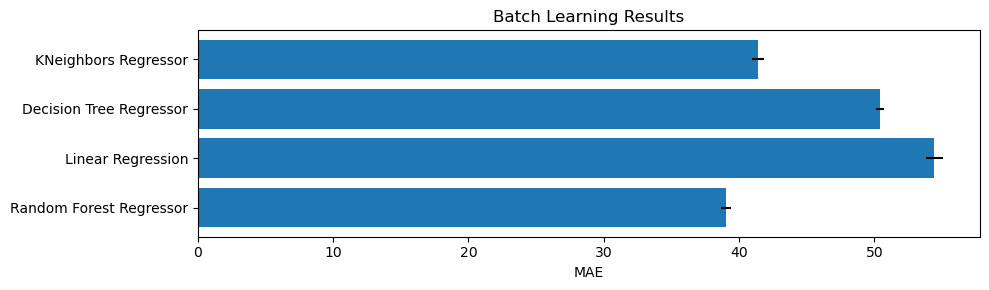

In [22]:
# Plot the scores comparing the different models
plt.figure(figsize=(10, 3))
plt.barh(list(mae_bl_results.keys()), [-score.mean() for score in mae_bl_results.values()], xerr=[score.std() for score in mae_bl_results.values()])
plt.title('Batch Learning Results')
plt.xlabel('MAE')
plt.tight_layout()
plt.show()

As observed from the graph, the Random Forest Regressor emerges as the best-performing model, a predictable outcome given its robust capability in handling complex data patterns and its inherent strength in reducing overfitting through ensemble learning.

## 6. Stream Learning
- **Stream Pipeline Implementation:** Develop a River stream pipeline for data preprocessing, model training, and evaluation.
- **Model Selection/Comparison:** Compare at least three machine learning models within River, including a Hoeffding Tree model.

For the Stream Learning section with River, we will implement a stream processing pipeline using River to continuously learn and predict pollution levels based on the data transformations we previously discussed. We will compare three different machine learning models provided by River, including a Hoeffding Tree model, to determine the best performer for our online learning scenario.

### Stream Learning Implementation
To start with, we need to adapt our dataset to a streaming format. River provides a convenient way to simulate streaming data from a DataFrame. We will use the iter_pandas method from River's stream module for this purpose.

In [23]:
from river import compose, preprocessing, evaluate, stream, drift, utils
from river.tree import HoeffdingTreeRegressor, HoeffdingAdaptiveTreeRegressor
from river import linear_model
from river.neighbors import KNNRegressor
from river.metrics import MAE
import itertools

In [24]:
# Function to evaluate the models and plot their predictions at the begginning and end of the stream
def evaluate_model(model, data_stream, i_top=1000, i_bottom=40000):
    metric = MAE()

    dates = []
    y_trues = []
    y_preds = []

    for x, y in data_stream:
        # Store the date
        dates.append(x['date'])

        # Obtain the prior prediction and update the model in one go
        y_pred = model.predict_one(x)
        model.learn_one(x, y)

        # Update the error metric
        metric.update(y, y_pred)

        # Store the true value and the prediction
        y_trues.append(y)
        y_preds.append(y_pred)

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
    
    # Plot the ground truth on the first subplot
    ax1.grid(alpha=0.75)
    ax1.plot(dates[i_top:i_top+1000], y_trues[i_top:i_top+1000], lw=1, color='#2ecc71', alpha=0.8, label='Ground truth')
    ax1.plot(dates[i_top:i_top+1000], y_preds[i_top:i_top+1000], lw=1, color='#e74c3c', alpha=0.8, label='Prediction')
    ax1.legend()
    ax1.set_title('Beginning of the stream')

    # Plot the prediction on the second subplot
    ax2.grid(alpha=0.75)
    ax2.plot(dates[i_bottom:i_bottom+1000], y_trues[i_bottom:i_bottom+1000], lw=1, color='#2ecc71', alpha=0.8, label='Ground truth')
    ax2.plot(dates[i_bottom:i_bottom+1000], y_preds[i_bottom:i_bottom+1000], lw=1, color='#e74c3c', alpha=0.8, label='Prediction')
    ax2.legend()
    ax2.set_title('End of the stream')

    # Display the metric on the figure title
    fig.suptitle(str(metric))

    # Adjust the layout
    plt.tight_layout()

    return metric

### Baseline Stream Learning Model

In [25]:
dataset_path = 'data/air_pollution_dataset_modified.csv'

# Wind direction mapping
mapping = {'SE': 1, 'cv': 2, 'NW': 3, 'NE': 4}
converter = lambda x: float(mapping[x])

data_stream = stream.iter_csv(dataset_path, target='pred_pollution', converters={'pred_pollution': float, 'current_pollution': float, 'dew': float,
                                                                                 'temp': float, 'press': float, 
                                                                                 'wnd_dir': converter, 'wnd_spd': float,
                                                                                 'snow': float, 'rain': float})
sample, target = next(data_stream)
print(sample)
print(target)

{'date': '2010-01-03 00:00:00', 'dew': -7.0, 'temp': -6.0, 'press': 1027.0, 'wnd_dir': 1.0, 'wnd_spd': 58.56, 'snow': 4.0, 'rain': 0.0, 'current_pollution': 129.0}
90.0


In [26]:
mae_ol_results = {}

In [27]:
# Discarding date column and scaling the data
to_discard=['date']
model = compose.Pipeline(compose.Discard(*to_discard), KNNRegressor(n_neighbors=5))

# Check the model's samples after preprocessing
for x, y in data_stream:
    model.learn_one(x, y)
    transformed_x = model.transform_one(x)
    print("Transformed:", {key: "{:.5f}".format(value) for key, value in transformed_x.items()})
    print("Predicted: ", model.predict_one(x))
    print("True Label: ", y)
    break

mae_ol_results['Baseline KNN Regressor'] = evaluate.progressive_val_score(dataset=data_stream, model=model, metric=MAE(), print_every=2500)

Transformed: {'dew': '-8.00000', 'temp': '-6.00000', 'press': '1026.00000', 'wnd_dir': '1.00000', 'wnd_spd': '61.69000', 'snow': '5.00000', 'rain': '0.00000', 'current_pollution': '148.00000'}
Predicted:  63.0
True Label:  63.0


[2,500] MAE: 41.4252
[5,000] MAE: 42.985
[7,500] MAE: 43.60952
[10,000] MAE: 44.8412
[12,500] MAE: 44.048688
[15,000] MAE: 44.899293
[17,500] MAE: 46.016743
[20,000] MAE: 45.97744
[22,500] MAE: 45.785413
[25,000] MAE: 45.1824
[27,500] MAE: 46.670131
[30,000] MAE: 46.762273
[32,500] MAE: 45.987729
[35,000] MAE: 46.098434
[37,500] MAE: 46.991909
[40,000] MAE: 46.31841
[42,500] MAE: 45.741567
[43,774] MAE: 45.805601


#### Debugging example

In [28]:
data_stream = stream.iter_csv('data/air_pollution_dataset_modified.csv', target='pred_pollution', converters={'current_pollution': float, 'dew': float, 'temp': float, 'press': float, 'wnd_spd': float, 'snow': float, 'rain': float, 'pred_pollution': float, 'date': pd.to_datetime})
 
model = (compose.Select('current_pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain')|preprocessing.StandardScaler())
model += (compose.Select('wnd_dir') | preprocessing.OneHotEncoder(drop_zeros=False))
model |= HoeffdingAdaptiveTreeRegressor(grace_period=250) 
 
x, y = next(data_stream)
print(model.debug_one(x))

# Train the model on the first 20 samples from the data stream
for x, y in itertools.islice(data_stream, 20):
    y_pred = model.predict_one(x)
    model.learn_one(x, y)
    print(model.debug_one(x))

0. Input
--------
current_pollution: 129.00000 (float)
date: 2010-01-03 00:00:00 (Timestamp)
dew: -7.00000 (float)
press: 1,027.00000 (float)
rain: 0.00000 (float)
snow: 4.00000 (float)
temp: -6.00000 (float)
wnd_dir: SE (str)
wnd_spd: 58.56000 (float)

1. Transformer union
--------------------
    1.0 ['current_pollution', 'dew', 'press', 'rain', 'snow', 'temp', 'wnd_spd'] | StandardScaler
    ---------------------------------------------------------------------------------------------
    current_pollution: 0.00000 (float)
    dew: 0.00000 (float)
    press: 0.00000 (float)
    rain: 0.00000 (float)
    snow: 0.00000 (float)
    temp: 0.00000 (float)
    wnd_spd: 0.00000 (float)

    1.1 ['wnd_dir'] | OneHotEncoder
    -------------------------------
    wnd_dir_SE: 1 (int)

current_pollution: 0.00000 (float)
dew: 0.00000 (float)
press: 0.00000 (float)
rain: 0.00000 (float)
snow: 0.00000 (float)
temp: 0.00000 (float)
wnd_dir_SE: 1 (int)
wnd_spd: 0.00000 (float)

2. HoeffdingAdaptiveT

### Model Selection for Stream Learning

We will implement three different models for our stream learning scenario:

- **Linear Regression** - A baseline model for regression tasks.
- **Random Forest Regressor** - An ensemble method for regression.
- **Hoeffding Tree Regressor** - A decision tree algorithm designed for streaming data.

For each model, we will create a corresponding River pipeline that includes necessary preprocessing steps (if any) and the model itself.

#### Linear Regression

In [29]:
data_stream = stream.iter_csv('data/air_pollution_dataset_modified.csv', target='pred_pollution', 
                                                                         converters={'current_pollution': float, 'dew': float, 
                                                                                     'temp': float, 'press': float, 'wnd_spd': float, 
                                                                                     'snow': float, 'rain': float, 
                                                                                     'pred_pollution': float, 'date': pd.to_datetime})

# Define the pipeline
model = (compose.Select('wnd_dir') | preprocessing.OneHotEncoder())
model += (compose.Select('current_pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain')|preprocessing.StandardScaler())
model |= linear_model.LinearRegression()
model
mae_ol_results['Linear Regressor'] = evaluate.progressive_val_score(dataset=data_stream, model=model, metric=MAE(), print_every=2500)

[2,500] MAE: 9,012,926,252.585682
[5,000] MAE: 7,955,244,846.852288
[7,500] MAE: 8,287,379,982.348388
[10,000] MAE: 6,865,291,961.717098
[12,500] MAE: 5,576,629,259.242336
[15,000] MAE: 4,652,693,306.092439
[17,500] MAE: 3,989,307,081.638108
[20,000] MAE: 3,580,366,631.877569
[22,500] MAE: 3,185,173,013.426263
[25,000] MAE: 3,256,433,102.722448
[27,500] MAE: 3,764,270,633.377815
[30,000] MAE: 3,501,529,466.443727
[32,500] MAE: 3,241,742,325.782372
[35,000] MAE: 3,012,728,648.966555
[37,500] MAE: 3,468,594,165.297094
[40,000] MAE: 3,263,956,105.028629
[42,500] MAE: 3,094,583,419.919006
[43,776] MAE: 3,020,893,106.219001


MAE: 3,020,893,106.219001

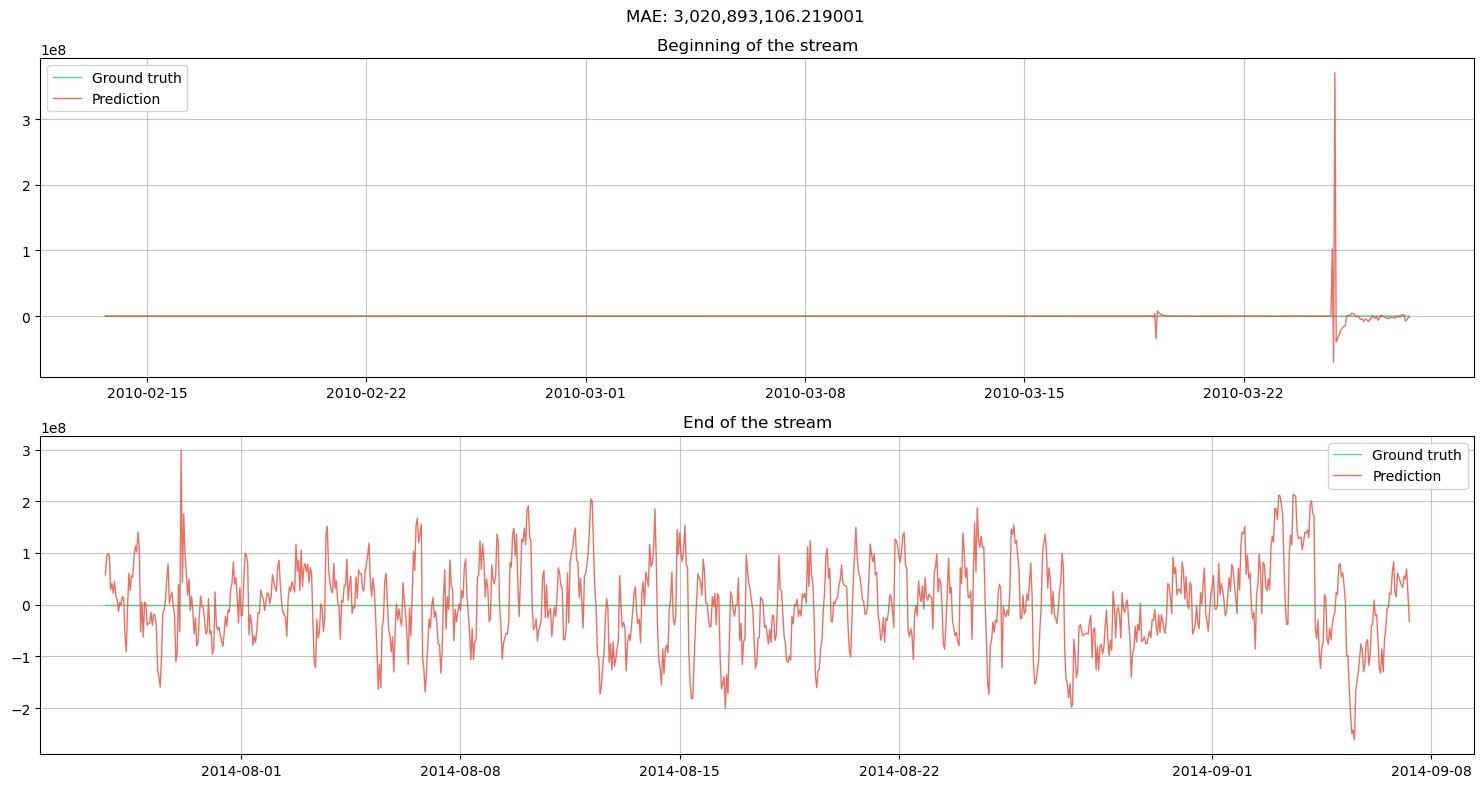

In [30]:
data_stream = stream.iter_csv('data/air_pollution_dataset_modified.csv', target='pred_pollution', converters={'current_pollution': float, 'dew': float, 'temp': float, 'press': float, 'wnd_spd': float, 'snow': float, 'rain': float, 'pred_pollution': float, 'date': pd.to_datetime})
model = (compose.Select('wnd_dir') | preprocessing.OneHotEncoder())
model += (compose.Select('current_pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain')|preprocessing.StandardScaler())
model |= linear_model.LinearRegression()
model
evaluate_model(model, data_stream)

#### KNN Regressor

In [31]:
data_stream = stream.iter_csv('data/air_pollution_dataset_modified.csv', target='pred_pollution', converters={'current_pollution': float, 'dew': float, 'temp': float, 'press': float, 'wnd_spd': float, 'snow': float, 'rain': float, 'pred_pollution': float, 'date': pd.to_datetime})

# Define the pipeline
model = (compose.Select('wnd_dir') | preprocessing.OneHotEncoder())
model += (compose.Select('current_pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain')|preprocessing.StandardScaler())
model |= KNNRegressor(n_neighbors=5)
model 
mae_ol_results['KNN Regressor'] = evaluate.progressive_val_score(dataset=data_stream, model=model, metric=MAE(), print_every=2500)

[2,500] MAE: 36.230807
[5,000] MAE: 37.844603
[7,500] MAE: 39.731549
[10,000] MAE: 41.181542
[12,500] MAE: 40.351969
[15,000] MAE: 40.855148
[17,500] MAE: 42.454252
[20,000] MAE: 42.815411
[22,500] MAE: 42.741583
[25,000] MAE: 42.047585
[27,500] MAE: 43.558408
[30,000] MAE: 43.656261
[32,500] MAE: 42.905188
[35,000] MAE: 43.067755
[37,500] MAE: 43.896016
[40,000] MAE: 43.2182
[42,500] MAE: 42.727652
[43,776] MAE: 42.860504


#### HoeffdingTreeRegressor

In [32]:
data_stream = stream.iter_csv('data/air_pollution_dataset_modified.csv', target='pred_pollution', converters={'current_pollution': float, 'dew': float, 'temp': float, 'press': float, 'wnd_spd': float, 'snow': float, 'rain': float, 'pred_pollution': float, 'date': pd.to_datetime})

# Define the pipeline
model = (compose.Select('wnd_dir') | preprocessing.OneHotEncoder())
model += (compose.Select('current_pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain')|preprocessing.StandardScaler())
model |= HoeffdingTreeRegressor( )
model
mae_ol_results['HT Regressor'] = evaluate.progressive_val_score(dataset=data_stream, model=model, metric=MAE(), print_every=2500)

[2,500] MAE: 37.387078
[5,000] MAE: 43.441324
[7,500] MAE: 45.043592
[10,000] MAE: 48.038938
[12,500] MAE: 47.603668
[15,000] MAE: 48.208401
[17,500] MAE: 49.646842
[20,000] MAE: 50.166142
[22,500] MAE: 49.571474
[25,000] MAE: 49.114359
[27,500] MAE: 51.199155
[30,000] MAE: 51.189193
[32,500] MAE: 50.169848
[35,000] MAE: 50.510574
[37,500] MAE: 51.325464
[40,000] MAE: 50.404441
[42,500] MAE: 49.939196
[43,776] MAE: 50.219067


#### Hoeffding Adaptive Tree Regressor

In [33]:
data_stream = stream.iter_csv('data/air_pollution_dataset_modified.csv', target='pred_pollution', converters={'current_pollution': float, 'dew': float, 'temp': float, 'press': float, 'wnd_spd': float, 'snow': float, 'rain': float, 'pred_pollution': float, 'date': pd.to_datetime})

# Define the pipeline
model = (compose.Select('wnd_dir') | preprocessing.OneHotEncoder())
model += (compose.Select('current_pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain')|preprocessing.StandardScaler())
model |=  HoeffdingAdaptiveTreeRegressor()
model
mae_ol_results['HAT Regressor'] = evaluate.progressive_val_score(dataset=data_stream, model=model, metric=MAE(), print_every=2500)

[2,500] MAE: 34.364252
[5,000] MAE: 33.306593
[7,500] MAE: 35.024616
[10,000] MAE: 36.895239
[12,500] MAE: 36.117889
[15,000] MAE: 35.381886
[17,500] MAE: 35.912867
[20,000] MAE: 36.214661
[22,500] MAE: 35.704299
[25,000] MAE: 35.360381
[27,500] MAE: 37.631947
[30,000] MAE: 37.401158
[32,500] MAE: 36.206459
[35,000] MAE: 36.346234
[37,500] MAE: 37.046875
[40,000] MAE: 36.222989
[42,500] MAE: 35.810151
[43,776] MAE: 35.962883


#### Hoeffding Adaptive Tree Regressor with tunning

In [34]:
data_stream = stream.iter_csv('data/air_pollution_dataset_modified.csv', target='pred_pollution', converters={'current_pollution': float, 'dew': float, 'temp': float, 'press': float, 'wnd_spd': float, 'snow': float, 'rain': float, 'pred_pollution': float, 'date': pd.to_datetime})

# Define the pipeline
model = (compose.Select('wnd_dir') | preprocessing.OneHotEncoder())
model += (compose.Select('current_pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain')|preprocessing.StandardScaler())
model |=  HoeffdingAdaptiveTreeRegressor(grace_period = 250,  drift_detector=drift.ADWIN())
model
mae_ol_results['HAT Regressor with tunning'] = evaluate.progressive_val_score(dataset=data_stream, model=model, metric=MAE(), print_every=2500)

[2,500] MAE: 36.449009
[5,000] MAE: 34.069357
[7,500] MAE: 35.341803
[10,000] MAE: 37.965014
[12,500] MAE: 36.956347
[15,000] MAE: 35.901712
[17,500] MAE: 36.578654
[20,000] MAE: 37.389186
[22,500] MAE: 36.504944
[25,000] MAE: 36.289234
[27,500] MAE: 37.338176
[30,000] MAE: 37.066166
[32,500] MAE: 36.106487
[35,000] MAE: 36.318134
[37,500] MAE: 36.942697
[40,000] MAE: 36.091512
[42,500] MAE: 35.63093
[43,776] MAE: 35.764162


#### Hoeffding Adaptive Tree Regressor with non-negative restriction

In [51]:
# Modified unction to evaluate the models, ensuring the predictions are non-negative
def evaluate_model_nonnegative(model, data_stream, i_top=1000, i_bottom=40000):
    metric = MAE()

    dates = []
    y_trues = []
    y_preds = []
    metric_list = []

    for x, y in data_stream:
        # Store the date
        dates.append(x['date'])

        # Obtain the prior prediction and update the model in one go
        y_pred = model.predict_one(x)

        # Ensure the prediction is not negative, as pollution cannot be negative
        y_pred = max(0, y_pred)

        model.learn_one(x, y)

        # Update the error metric
        metric.update(y, y_pred)
        metric_list.append(metric.get())
        
        # Store the true value and the prediction
        y_trues.append(y)
        y_preds.append(y_pred)

    # Create two subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 9))
    
    # Plot the ground truth on the first subplot
    ax1.grid(alpha=0.75)
    ax1.plot(dates[i_top:i_top+1000], y_trues[i_top:i_top+1000], lw=1, color='#2ecc71', alpha=0.8, label='Ground truth')
    ax1.plot(dates[i_top:i_top+1000], y_preds[i_top:i_top+1000], lw=1, color='#e74c3c', alpha=0.8, label='Prediction')
    ax1.legend()
    ax1.set_title('Beginning of the stream')

    # Plot the prediction on the second subplot
    ax2.grid(alpha=0.75)
    ax2.plot(dates[i_bottom:i_bottom+1000], y_trues[i_bottom:i_bottom+1000], lw=1, color='#2ecc71', alpha=0.8, label='Ground truth')
    ax2.plot(dates[i_bottom:i_bottom+1000], y_preds[i_bottom:i_bottom+1000], lw=1, color='#e74c3c', alpha=0.8, label='Prediction')
    ax2.legend()
    ax2.set_title('End of the stream')

    # Plot the prediction on the second subplot
    ax3.grid(alpha=0.75)
    ax3.plot(dates, metric_list, lw=1, color='#2ecc71', alpha=0.8)
    ax3.legend()
    ax3.set_title('MAE evolution')

    fig.suptitle(str(metric))
    plt.tight_layout()
    
    return metric

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


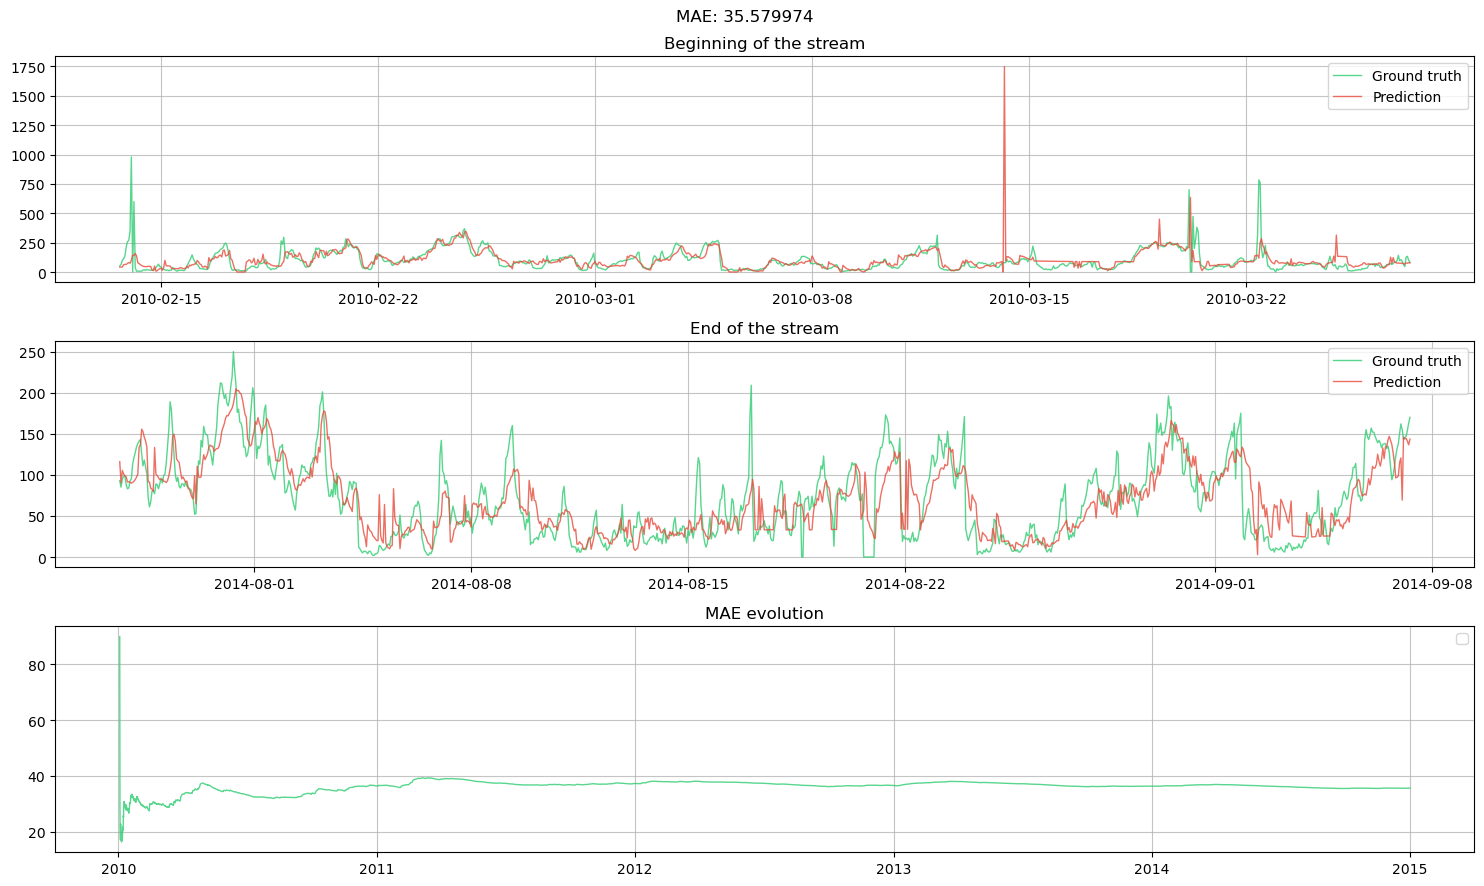

In [52]:
data_stream = stream.iter_csv('data/air_pollution_dataset_modified.csv', target='pred_pollution', converters={'current_pollution': float, 'dew': float, 'temp': float, 'press': float, 'wnd_spd': float, 'snow': float, 'rain': float, 'pred_pollution': float, 'date': pd.to_datetime})

# Define the pipeline
model = (compose.Select('wnd_dir') | preprocessing.OneHotEncoder())
model += (compose.Select('current_pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain')|preprocessing.StandardScaler())
model |=  HoeffdingAdaptiveTreeRegressor(grace_period = 250,  drift_detector=drift.ADWIN())

mae_ol_results['HAT Non-Negative Regressor'] = evaluate_model_nonnegative(model, data_stream)

### Metric Comparison

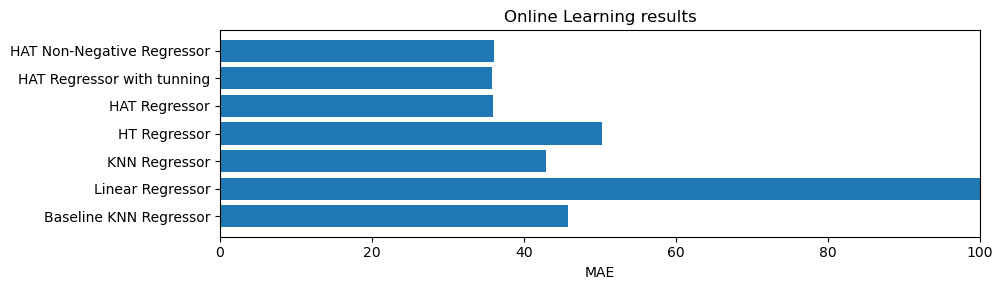

In [37]:
# Plot the scores comparing the different models
plt.figure(figsize=(10, 3))
plt.barh(list(mae_ol_results.keys()), [score.get() for score in mae_ol_results.values()])
plt.title('Online Learning results')
plt.xlabel('MAE')
plt.tight_layout()
plt.xlim(0, 100)
plt.show()

## 7. Results and Conclusions 
Together with notebook presentation max. 2 points. 
* Oral presentation 2 points.

In [38]:
mae_bl_results

{'Random Forest Regressor': array([-39.1219002 , -39.20220691, -38.69515283, -39.62050233,
        -38.51814188]),
 'Linear Regression': array([-54.31692492, -54.40172804, -54.77876898, -55.25944609,
        -53.36076965]),
 'Decision Tree Regressor': array([-50.08908177, -50.19388921, -50.36282125, -50.79731582,
        -50.75579669]),
 'KNeighbors Regressor': array([-41.96295112, -41.37628784, -41.14601942, -41.85229012,
        -40.79175328])}

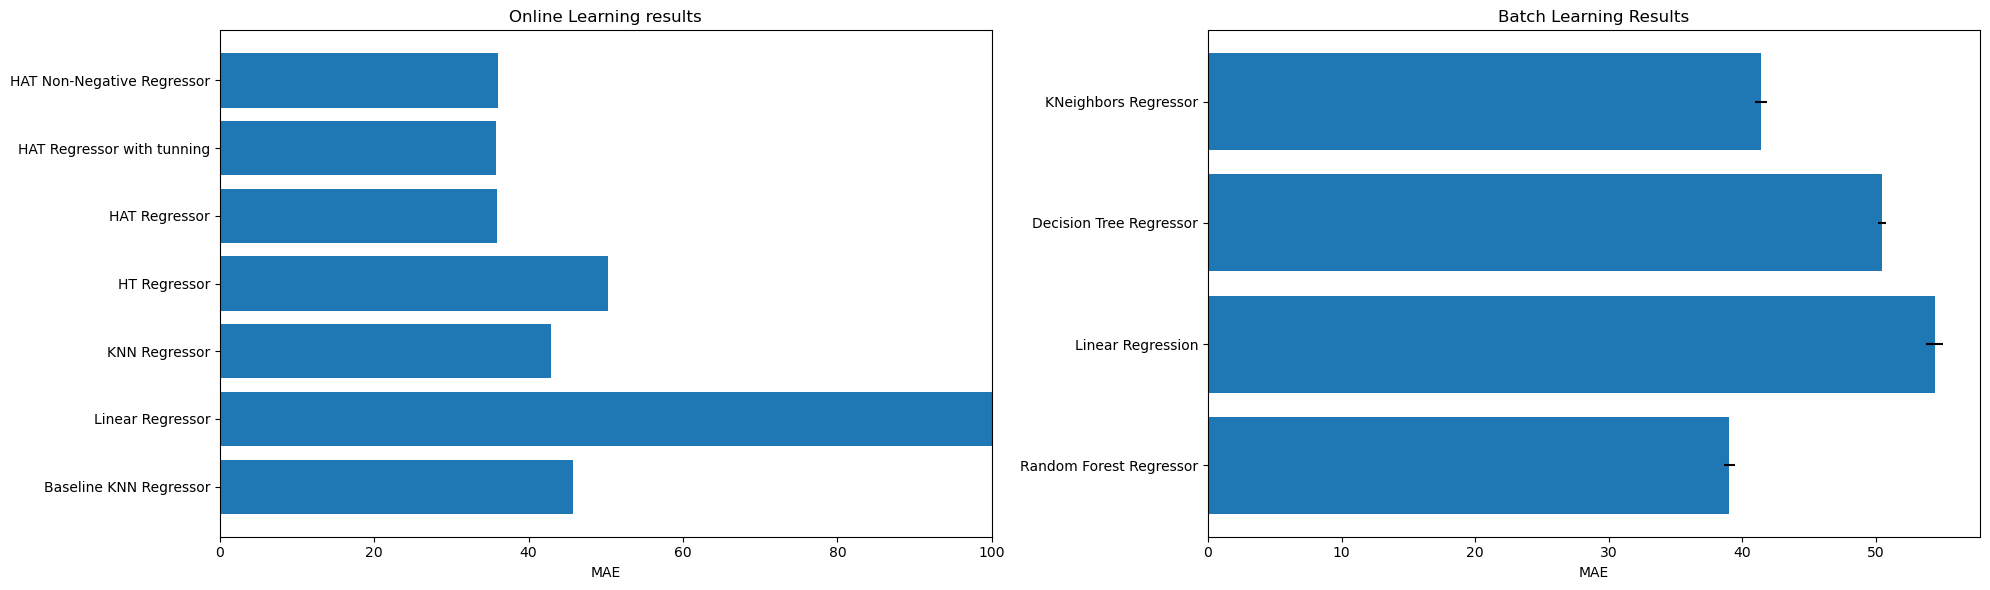

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot the scores comparing the different models in the first subplot
ax1.barh(list(mae_ol_results.keys()), [score.get() for score in mae_ol_results.values()])
ax1.set_title('Online Learning results')
ax1.set_xlabel('MAE')
ax1.set_xlim(0, 100)

# Plot the scores comparing the different models in the second subplot
ax2.barh(list(mae_bl_results.keys()), [-score.mean() for score in mae_bl_results.values()], xerr=[score.std() for score in mae_bl_results.values()])
ax2.set_title('Batch Learning Results')
ax2.set_xlabel('MAE')

plt.tight_layout()
plt.show()

Analyzing the online learning results, the Hoeffding Adaptive Tree (HAT) Regressor stands out as the best performer, showcasing its strength in handling the evolving data stream. Close behind, the HAT Non-Negative Regressor shows that imposing a non-negativity constraint on predictions doesn’t necessarily improve results, perhaps due to the nature of pollution data where non-negative values are not expected from the beggining. Surprisingly, the fine-tuned HAT Regressor doesn't match the performance of the untuned version, hinting that parameter tuning might not always align well with the fluid dynamics of online data streams.

The KNN Regressor and its baseline variant trail behind the HAT models. Finally, the HT Regressor and Linear Regressor lag further, with the Linear Regressor in particular struggling, aligning with the challenges inherent in adapting to streaming data.

When we consider these online learning models in contrast with the batch learning results, it's evident that the online models (besides the Linear Regressor) hold their ground with reasonably competitive MAE scores. This is particularly notable because online learning tasks are inherently more complex due to the requirement to update predictions in real-time as new data arrives. Despite the complexities, the online learning models do not trail far behind batch models, affirming their capability to adapt and learn incrementally. Moreover, an important advantage of online learning is its ability to start making predictions right away, while batch learning models require accumulation of substantial historical data to begin yielding accurate predictions, highlighting the agility and real-time applicability of online learning models in dynamic environments.

Finally, batch learning models might showcase lower error rates in a static test environment, but they would struggle with the real-time updates that online learning models are designed to handle. Thus, the acceptability of the online learning models' performance is emphasized, particularly considering the real-world challenges they are equipped to tackle.

### Comparison with sklearn equivalent of river models

In [40]:
from river.compat import convert_river_to_sklearn

# Define the pipeline
model = (compose.Select('wnd_dir') | preprocessing.OneHotEncoder())
model += (compose.Select('current_pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain')|preprocessing.StandardScaler())
model |=  HoeffdingAdaptiveTreeRegressor(grace_period = 250,  drift_detector=drift.ADWIN())

# Convert the model to a scikit-learn compatible model
model = convert_river_to_sklearn(model)
scores = cross_val_score(model, X, y, scoring=mae_scorer, cv=cv)
mae_bl_results['Random Forest Regressor'] = scores
print(f'MAE = {-scores.mean():.4f} (± {scores.std():.4f})')

InvalidParameterError: The 'y' parameter of cross_val_score must be an array-like or None. Got 71.0 instead.